# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
# use python3 kernel

In [1]:
import sys
import os
sys.path.append(os.getcwd())

In [2]:
sys.path

['',
 '/usr/lib/python35.zip',
 '/usr/lib/python3.5',
 '/usr/lib/python3.5/plat-x86_64-linux-gnu',
 '/usr/lib/python3.5/lib-dynload',
 '/usr/local/lib/python3.5/dist-packages',
 '/usr/local/lib/python3.5/dist-packages/wordcloud-1.4.1-py3.5-linux-x86_64.egg',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.5/dist-packages',
 '/usr/local/lib/python3.5/dist-packages/IPython/extensions',
 '/home/info/.ipython',
 '/home/info/udacity/naturalLaguageProcesssing/project/machineTranslation/aind2-nlp-capstone']

In [3]:
import keras
keras.__version__

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.0'

In [4]:
%load_ext autoreload
import helper, tests
%autoreload 1

In [5]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional 
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [6]:
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU

In [7]:
import tensorflow
tensorflow.__version__

'1.2.0'

### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2042868447855578603
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 10278184551
locality {
  bus_id: 1
}
incarnation: 777071094548473999
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0"
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [9]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [10]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [11]:
len(english_sentences)

137861

From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [12]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [13]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    text_tokenized = tokenizer.texts_to_sequences(x)
    text_tokenizer = tokenizer
    return text_tokenized, text_tokenizer
tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'is': 19, 'this': 18, 'the': 1, 'quick': 2, 'fox': 5, 'jumps': 6, 'lexicography': 15, 'short': 20, 'prize': 17, 'of': 14, 'won': 16, 'brown': 4, 'dog': 9, 'jove': 11, 'over': 7, 'by': 10, 'study': 13, 'a': 3, 'my': 12, 'lazy': 8, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [14]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length == None:
        length = max(x, key=len)
        length = len(length)
    return pad_sequences(x, maxlen=length, padding='post') 
tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [15]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [22]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [18]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 0.001
    input_seq = Input(shape=input_shape[1:])
    rnn = GRU(english_vocab_size, return_sequences=True)(input_seq )
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 4s 39us/step - loss: 2.7197 - acc: 0.4657 - val_loss: nan - val_acc: 0.5319
Epoch 2/10
110288/110288 [==============================] - 4s 34us/step - loss: 1.7702 - acc: 0.5696 - val_loss: nan - val_acc: 0.5954
Epoch 3/10
110288/110288 [==============================] - 4s 34us/step - loss: 1.5132 - acc: 0.6030 - val_loss: nan - val_acc: 0.6125
Epoch 4/10
110288/110288 [==============================] - 4s 33us/step - loss: 1.3873 - acc: 0.6221 - val_loss: nan - val_acc: 0.6309
Epoch 5/10
110288/110288 [==============================] - 4s 34us/step - loss: 1.2952 - acc: 0.6375 - val_loss: nan - val_acc: 0.6381
Epoch 6/10
110288/110288 [==============================] - 4s 34us/step - loss: 1.2222 - acc: 0.6472 - val_loss: nan - val_acc: 0.6527
Epoch 7/10
110288/110288 [==============================] - 4s 34us/step - loss: 1.1673 - acc: 0.6566 - val_loss: nan - val_acc: 0.66

In [19]:
text = ''
for x in tmp_x[:1][0]:
     for item in english_tokenizer.word_index.items():
        if x == item[1]:
            text += item[0]
            #print('item', item[0])
            text += ' '
print('Input text was:', text)

Input text was: new jersey is sometimes quiet during autumn and it is snowy in april 


### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [39]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.001
    
    input_seq = Input(shape=input_shape[1:])
    emb = Embedding(input_dim=english_vocab_size ,output_dim=output_sequence_length)(input_seq)
    rnn = GRU(output_sequence_length, return_sequences=True)(emb)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
tests.test_embed_model(embed_model)


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train the neural network
embed_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


embed_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=50, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(embed_model.predict(tmp_x[:1])[0], french_tokenizer))


Train on 110288 samples, validate on 27573 samples
Epoch 1/50
110288/110288 [==============================] - 4s 37us/step - loss: 4.6588 - acc: 0.3853 - val_loss: nan - val_acc: 0.4093
Epoch 2/50
110288/110288 [==============================] - 4s 32us/step - loss: 3.1430 - acc: 0.4102 - val_loss: nan - val_acc: 0.4129
Epoch 3/50
110288/110288 [==============================] - 4s 32us/step - loss: 3.0076 - acc: 0.4119 - val_loss: nan - val_acc: 0.4130
Epoch 4/50
110288/110288 [==============================] - 3s 32us/step - loss: 2.7134 - acc: 0.4398 - val_loss: nan - val_acc: 0.4614
Epoch 5/50
110288/110288 [==============================] - 3s 31us/step - loss: 2.3099 - acc: 0.4982 - val_loss: nan - val_acc: 0.5367
Epoch 6/50
110288/110288 [==============================] - 3s 31us/step - loss: 1.9667 - acc: 0.5583 - val_loss: nan - val_acc: 0.5827
Epoch 7/50
110288/110288 [==============================] - 3s 31us/step - loss: 1.7045 - acc: 0.6018 - val_loss: nan - val_acc: 0.61

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [55]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.01
    input_seq = Input(shape=input_shape[1:])
    
    rnn = Bidirectional(GRU(output_sequence_length, return_sequences=True))(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
   
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
tests.test_bd_model(bd_model)


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# TODO: Train the neural network
bd_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


embed_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=25, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(bd_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/25
110288/110288 [==============================] - 6s 50us/step - loss: 1.2632 - acc: 0.6492 - val_loss: nan - val_acc: 0.6515
Epoch 2/25
110288/110288 [==============================] - 5s 43us/step - loss: 1.2259 - acc: 0.6539 - val_loss: nan - val_acc: 0.6550
Epoch 3/25
110288/110288 [==============================] - 5s 44us/step - loss: 1.1954 - acc: 0.6572 - val_loss: nan - val_acc: 0.6588
Epoch 4/25
110288/110288 [==============================] - 5s 44us/step - loss: 1.1711 - acc: 0.6600 - val_loss: nan - val_acc: 0.6605
Epoch 5/25
110288/110288 [==============================] - 5s 43us/step - loss: 1.1520 - acc: 0.6627 - val_loss: nan - val_acc: 0.6625
Epoch 6/25
110288/110288 [==============================] - 5s 43us/step - loss: 1.1386 - acc: 0.6643 - val_loss: nan - val_acc: 0.6663
Epoch 7/25
110288/110288 [==============================] - 5s 44us/step - loss: 1.1264 - acc: 0.6662 - val_loss: nan - val_acc: 0.66

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [80]:
from keras.layers import RepeatVector

In [81]:
RepeatVector()

keras.layers.core.RepeatVector

In [95]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    latent_dim = 256
    learning_rate=0.01
    inputs = Input(shape=input_shape[1:])
    encoded = LSTM(output_sequence_length)(inputs)
    encoder_out = Dense(latent_dim)(encoded)
    
    
    decoded = RepeatVector(output_sequence_length)(encoder_out)
    decoded = LSTM(latent_dim, return_sequences=True)(decoded)
    logits = TimeDistributed(Dense(french_vocab_size, activation=('softmax')))(decoded)
    

    autoencoder = Model(inputs=inputs, outputs=logits)
    autoencoder.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return autoencoder
tests.test_encdec_model(encdec_model)

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# OPTIONAL: Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

encdec_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


encdec_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=100, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(encdec_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/100
110288/110288 [==============================] - 10s 93us/step - loss: 2.7356 - acc: 0.4466 - val_loss: nan - val_acc: 0.5254
Epoch 2/100
110288/110288 [==============================] - 8s 70us/step - loss: 1.7675 - acc: 0.5532 - val_loss: nan - val_acc: 0.5753
Epoch 3/100
110288/110288 [==============================] - 8s 69us/step - loss: 1.5588 - acc: 0.5846 - val_loss: nan - val_acc: 0.6045
Epoch 4/100
110288/110288 [==============================] - 8s 70us/step - loss: 1.4613 - acc: 0.6031 - val_loss: nan - val_acc: 0.6163
Epoch 5/100
110288/110288 [==============================] - 8s 70us/step - loss: 1.3599 - acc: 0.6232 - val_loss: nan - val_acc: 0.6298
Epoch 6/100
110288/110288 [==============================] - 8s 70us/step - loss: 1.3395 - acc: 0.6256 - val_loss: nan - val_acc: 0.6365
Epoch 7/100
110288/110288 [==============================] - 8s 69us/step - loss: 1.3911 - acc: 0.6130 - val_loss: nan - val_a

Epoch 60/100
110288/110288 [==============================] - 8s 68us/step - loss: 0.9730 - acc: 0.6988 - val_loss: nan - val_acc: 0.7096
Epoch 61/100
110288/110288 [==============================] - 8s 69us/step - loss: 0.9229 - acc: 0.7102 - val_loss: nan - val_acc: 0.7102
Epoch 62/100
110288/110288 [==============================] - 8s 68us/step - loss: 0.9861 - acc: 0.6955 - val_loss: nan - val_acc: 0.7072
Epoch 63/100
110288/110288 [==============================] - 8s 69us/step - loss: 0.9698 - acc: 0.6983 - val_loss: nan - val_acc: 0.6399
Epoch 64/100
110288/110288 [==============================] - 8s 70us/step - loss: 0.9828 - acc: 0.6941 - val_loss: nan - val_acc: 0.7041
Epoch 65/100
110288/110288 [==============================] - 8s 68us/step - loss: 0.9629 - acc: 0.6973 - val_loss: nan - val_acc: 0.7085
Epoch 66/100
110288/110288 [==============================] - 8s 70us/step - loss: 0.9031 - acc: 0.7130 - val_loss: nan - val_acc: 0.7172
Epoch 67/100
110288/110288 [======

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [18]:
from keras.layers import Dropout
from keras.layers import CuDNNLSTM

In [38]:
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

In [22]:
model_final = final_model = model_final(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


In [27]:
#model_final.output_shape
french_vocab_size

344

In [28]:
max_french_sequence_length

21

In [39]:
tmp_x.shape

(137861, 21, 1)

In [41]:
example = tmp_x[0]

In [43]:
example.shape

(21, 1)

In [48]:
output_sequence_length = max_french_sequence_length
english_vocab_size = english_vocab_size
french_vocab_size = french_vocab_size

In [51]:
print("out", output_sequence_length)
print("eng", english_vocab_size)
print("french", french_vocab_size)

out 21
eng 199
french 344


In [54]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=tmp_x.shape[1:])

In [56]:
from keras.layers import LSTM

In [57]:
encoder = LSTM(english_vocab_size, return_state=True)

In [59]:
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [63]:
encoder_states = [state_h, state_c]

In [66]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=tmp_x.shape[1:])
encoder = LSTM(english_vocab_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]




In [29]:
english_sentences[0]

'new jersey is sometimes quiet during autumn , and it is snowy in april .'

In [30]:
french_sentences[0]

"new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."

In [16]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 0.001
    embedding_dimention = 256
    num_encoder_tokens = english_vocab_size
    num_decoder_tokens = french_vocab_size
    encoder_inputs = Input(shape= input_shape[1:])
    encoder = CuDNNLSTM(embedding_dimention, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape= (french_vocab_size, 1))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model
tests.test_model_final(model_final)

ValueError: Input 0 is incompatible with layer cu_dnnlstm_1: expected ndim=3, found ndim=2

In [47]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=french_vocab_size
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
emb = Embedding(input_dim=english_vocab_size ,output_dim=output_sequence_length)(input_seq)

In [52]:
max_english_sequence_length

15

In [1]:
tmp_x.shape

NameError: name 'tmp_x' is not defined

In [19]:
# TODO: Train the final model
# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

final_model = model_final(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


final_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=100, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(final_model.predict(tmp_x[:1])[0], french_tokenizer))

(137861, 21, 1)


NameError: name 'Sequential' is not defined

In [16]:
from keras import  Sequential
from keras.layers import Dropout


In [18]:
max_french_sequence_length , english_vocab_size

(21, 199)

In [63]:
french_vocab_size, max_english_sequence_length

(344, 15)

In [57]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 0.001
    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size, output_dim= english_vocab_size, mask_zero=False, input_length=input_shape[-1]))
    model.add(Bidirectional(CuDNNLSTM(output_sequence_length, return_sequences=False)))
    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(CuDNNLSTM(output_sequence_length, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(CuDNNLSTM(output_sequence_length, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(CuDNNLSTM(output_sequence_length, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(CuDNNLSTM(output_sequence_length, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(french_vocab_size)))
    model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['sparse_categorical_accuracy'])
    return model




tests.test_model_final(model_final)
print('Final Model Loaded')


Final Model Loaded


## Prediction (IMPLEMENTATION)

In [53]:
import matplotlib.pyplot as plt
from keras.models import model_from_json


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Train on 110288 samples, validate on 27573 samples
Epoch 1/20
110288/110288 [==============================] - 18s 166us/step - loss: 3.5685 - sparse_categorical_accuracy: 0.4198 - val_loss: nan - val_sparse_categorical_accuracy: 0.4780
Epoch 2/20
110288/110288 [==============================] - 15s 135us/step - loss: 3.0556 - sparse_categorical_accuracy: 0.4561 - val_loss: nan - val_sparse_categorical_accuracy: 0.5027
Epoch 3/20
110288/110288 [==============================] - 15s 136us/step - loss: 2.8761 - sparse_categorical_accuracy: 0.4610 - val_loss: nan - val_sparse_categorical_accuracy: 0.4762
Epoch 4/20
110288/110288 [==============================] - 15s 135us/step - loss: 3.2603 - sparse_categorical_accuracy: 0.4044 - val_loss: nan - val_sparse_categorical_accuracy: 0.4233
Epoch 5/20
110288/110288 [==============================] - 15s 135us/step - loss: 3.3349 - sparse_categorical_accuracy: 0.4288 - val_loss: nan - val_sparse_categorical_accuracy: 0.4652
Epoch 6/20
110288/1

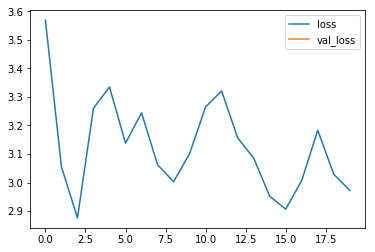

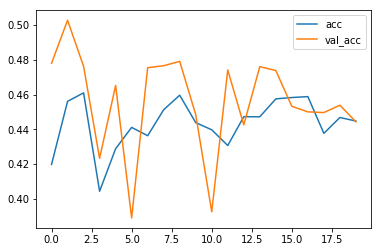

Sample 1:
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Il a vu un vieux camion jaune
Sample 2:
est est est est est est est en en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [58]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # TODO: Train neural network using model_finalyy
    tmp_x = pad(preproc_english_sentences, max_english_sequence_length)
    continue_training = False
    if not continue_training:
        model = model_final(tmp_x.shape,max_french_sequence_length, english_vocab_size, french_vocab_size)
    else:
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights("model.h5")
        model = loaded_model
        model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['sparse_categorical_accuracy'])
        print("Loaded model from disk")
    r = model.fit(tmp_x, preproc_french_sentences, batch_size=256, epochs=20, validation_split=0.2)
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    plt.plot(r.history['loss'],label='loss')
    plt.plot(r.history['val_loss'],label='val_loss')
    plt.legend()
    plt.show()
    plt.plot(r.history['sparse_categorical_accuracy'],label='acc')
    plt.plot(r.history['val_sparse_categorical_accuracy'],label='val_acc')
    plt.legend()
    plt.show()
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


model = final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

In [19]:
x_tk = english_tokenizer
x = preproc_english_sentences

In [20]:
sentence = 'he saw a old yellow truck'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
sentences = np.array([sentence[0], x[0]])

In [21]:
sentences.shape

(2, 15)

In [28]:
tmp_x = pad(preproc_english_sentences, max_english_sequence_length)
#tmp_x = tmp_x.reshape((-1, preproc_english_sentences.shape[-2]))
tmp_x.shape

(137861, 15)

In [25]:
sentences

array([[ 26, 127, 100, 111, 112, 101,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 17,  23,   1,   8,  67,   4,  39,   7,   3,   1,  55,   2,  44,
          0,   0]], dtype=int32)

In [37]:
tmp_x = pad(preproc_english_sentences, max_english_sequence_length)
input_shape= tmp_x.shape
output_sequence_length = max_french_sequence_length
learning_rate = 0.1
model = Sequential()
model.add(Embedding(input_dim=english_vocab_size, output_dim= english_vocab_size, mask_zero=False, input_length=input_shape[-1]))
model.add(Bidirectional(GRU(output_sequence_length, return_sequences=False)))
model.add(RepeatVector(output_sequence_length))
model.add(Bidirectional(GRU(output_sequence_length, return_sequences=True)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1024,activation='relu')))
model.add(TimeDistributed(Dense(french_vocab_size)))
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['sparse_categorical_accuracy'])
r = model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=1, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/1
110288/110288 [==============================] - 11s 98us/step - loss: 6.0088 - sparse_categorical_accuracy: 0.1041 - val_loss: nan - val_sparse_categorical_accuracy: 0.0061


In [38]:
r.history

{'loss': [6.008828920081861],
 'sparse_categorical_accuracy': [0.10412435989703156],
 'val_loss': [nan],
 'val_sparse_categorical_accuracy': [0.006137819638450713]}

In [30]:
model.predict(sentences)

array([[[ 557.8807 ,  559.5869 ,  564.68005, ..., -555.3662 ,
         -556.5785 , -556.09174],
        [ 569.66724,  577.0893 ,  582.60645, ..., -572.90594,
         -574.4993 , -573.87744],
        [ 548.4464 ,  552.77466,  557.66504, ..., -547.7552 ,
         -549.01733, -548.3152 ],
        ...,
        [ 567.2832 ,  573.0085 ,  578.25635, ..., -568.3038 ,
         -569.7967 , -569.08014],
        [ 567.28595,  573.0155 ,  578.2646 , ..., -568.3124 ,
         -569.8052 , -569.0888 ],
        [ 566.03796,  571.54504,  576.7176 , ..., -566.74005,
         -568.2357 , -567.50903]],

       [[ 593.7927 ,  604.62744,  610.55756, ..., -601.42267,
         -604.50867, -604.2785 ],
        [ 572.92725,  585.89954,  589.4983 , ..., -579.02057,
         -581.2581 , -579.8673 ],
        [ 581.8829 ,  596.71234,  600.4791 , ..., -590.03204,
         -592.3152 , -590.93243],
        ...,
        [ 571.6823 ,  585.5598 ,  589.17584, ..., -578.72864,
         -580.9065 , -579.5239 ],
        [ 57

In [48]:
input_layer = model.layers[0]

In [51]:
input_layer.output_shape

(None, 21, 199)

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

In [ ]:
!!python -m nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?